In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

from concepts import concept_instances
from utils import load_data, prepare_folders

In [3]:
prepare_folders('../gan')
data = load_data()
concept = concept_instances['ball right paddle (b)']
concept.prepare_data(data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input is (batch_size, 100, 1, 1)
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # State size: (batch_size, 512, 4, 4)
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # State size: (batch_size, 256, 8, 8)
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # State size: (batch_size, 128, 16, 16)
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # State size: (batch_size, 64, 32, 32)
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # State size: (batch_size, 32, 64, 64)
            
            # Adjusted kernel size, stride, and padding for the final layer
            nn.ConvTranspose2d(32, 4, 21, 1, 0, bias=False),
            nn.Sigmoid()
            # Output size: (batch_size, 4, 84, 84)
        )

    def forward(self, input):
        return self.main(input) * 255.0

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)  # this flattens the output tensor

In [7]:
# Initialize models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Set up loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0001)
optimizerG = optim.Adam(netG.parameters(), lr=0.0001)

# Convert to a dataset
train_obs = torch.tensor(concept.train_obs).float().to(device)
test_obs = torch.tensor(concept.test_obs).float().to(device)
obs_dataset = TensorDataset(train_obs)

# Create a DataLoader from the dataset
batch_size = 256  # Set your desired batch size
obs_loader = DataLoader(obs_dataset, batch_size=batch_size, shuffle=True)

[1]	Loss_D: 2.5718	Loss_G: 10.3924	D(x): 0.8630	D(G(z)): 0.9006/0.0000
[2]	Loss_D: 0.0411	Loss_G: 4.2215	D(x): 0.9936	D(G(z)): 0.0337/0.0150
[3]	Loss_D: 0.0208	Loss_G: 4.3841	D(x): 0.9985	D(G(z)): 0.0190/0.0125
[4]	Loss_D: 0.0153	Loss_G: 4.6303	D(x): 0.9988	D(G(z)): 0.0139/0.0098
[5]	Loss_D: 0.0124	Loss_G: 4.8180	D(x): 1.0000	D(G(z)): 0.0123/0.0081
[6]	Loss_D: 0.0134	Loss_G: 4.7632	D(x): 0.9995	D(G(z)): 0.0128/0.0085
[7]	Loss_D: 0.0231	Loss_G: 4.0548	D(x): 1.0000	D(G(z)): 0.0228/0.0173
[8]	Loss_D: 0.0223	Loss_G: 4.0746	D(x): 1.0000	D(G(z)): 0.0220/0.0170
[9]	Loss_D: 0.1902	Loss_G: 1.8762	D(x): 1.0000	D(G(z)): 0.1720/0.1585
[10]	Loss_D: 8.0201	Loss_G: 0.0424	D(x): 1.0000	D(G(z)): 0.9967/0.9619
[11]	Loss_D: 0.1685	Loss_G: 1.7897	D(x): 1.0000	D(G(z)): 0.1545/0.1704
[12]	Loss_D: 0.7875	Loss_G: 1.4629	D(x): 1.0000	D(G(z)): 0.5344/0.2422
[13]	Loss_D: 0.2896	Loss_G: 7.2731	D(x): 0.9161	D(G(z)): 0.0217/0.0007
[14]	Loss_D: 0.6178	Loss_G: 2.2896	D(x): 0.8469	D(G(z)): 0.1644/0.1026
[15]	Loss_D: 1

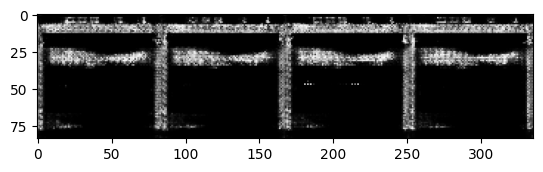

In [8]:
num_epochs = 500
for epoch in range(num_epochs):
    for i, (data,) in enumerate(obs_loader):
        # Train Discriminator
        netD.zero_grad()
        real_data = data.to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        output = netD(real_data)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print statistics
        if i % 100 == 0:
            print(f'[{epoch + 1}]\t'
                  f'Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t'
                  f'D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

            if epoch % 10 == 0:
                # Image Reconstruction example
                with torch.no_grad():
                    noise = torch.randn(1, 100, 1, 1, device=device)
                    generated_data = netG(noise)
                    plt.imshow(np.concatenate(generated_data.reshape(4, 84, 84).detach().cpu().numpy(), axis=1), cmap='gray')
                    # save
                    plt.savefig(f'../gan/{epoch}.png')